In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 15.9 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics import CalibrationError

In [ ]:
trainset = datasets.CIFAR100('cifar',
            train=True, download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor()
            ]))

testset = datasets.CIFAR100('cifar', False,
                          transform = transforms.Compose([
                              transforms.Resize((32, 32)),
                              transforms.ToTensor()
                          ]))

trainset = DataLoader(trainset, batch_size=32, shuffle=True)
testset = DataLoader(testset, batch_size=32, shuffle=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 101492401.87it/s]


Extracting cifar/cifar-10-python.tar.gz to cifar


**Define the Resnet and the Classifier**

In [ ]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Scaling Parameter
        # self.init_scaling_factor = torch.ones(num_classes)
        # self.scaling_factor = torch.nn.Parameter(self.init_scaling_factor, requires_grad=True)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

In [ ]:
def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)

def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)


def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)


def test():
    net = ResNet18(img_channels=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())

**Train the model**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(img_channels=3, num_classes=10).to(device)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
error = CalibrationError(num_classes=10,
                         task='multiclass',norm='l1',n_bins=30)

In [ ]:
%%time
from tqdm import tqdm

num_epochs = 15
loss_li, acc_li, epoch_error = [], [], []
for epoch in range(num_epochs):
    for idx, (x, label) in tqdm(enumerate(trainset),desc=f"Epoch {epoch+1}"):
        x, label = x.to(device), label.to(device)
        #print(x.shape, label.shape)
        logits = model(x) # b [b, 10]
        loss = criterion(logits, label) # label: [b]

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        tot_corr = 0
        tot_num = 0
        epoch_calib_error = 0
        for x, label in testset:
            x, label = x.to(device), label.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            batch_calib_error = error(logits.softmax(dim=1).detach().cpu(),label.cpu())
            epoch_calib_error = epoch_calib_error + batch_calib_error
            tot_corr += torch.eq(pred, label).float().sum().item() # using item() to convert tensor to number
            tot_num += x.size(0)
        acc = tot_corr / tot_num

    loss_li.append(loss.item())
    acc_li.append(acc)
    epoch_error.append(epoch_calib_error)

    print('epoch: {}, loss: {}, acc: {}, Error: {}'.format(epoch+1, loss, acc, epoch_calib_error))

Epoch 1: 1563it [07:35,  3.43it/s]


epoch: 1, loss: 1.0528455972671509, acc: 0.5887, Error: 82.30543518066406


Epoch 2: 1563it [07:47,  3.34it/s]


epoch: 2, loss: 0.9282339215278625, acc: 0.6075, Error: 82.15082550048828


Epoch 3: 1563it [08:16,  3.15it/s]


epoch: 3, loss: 1.2789616584777832, acc: 0.662, Error: 75.45269012451172


Epoch 4: 1563it [08:29,  3.07it/s]


epoch: 4, loss: 1.0203750133514404, acc: 0.6712, Error: 74.43913269042969


Epoch 5: 1563it [08:39,  3.01it/s]


epoch: 5, loss: 0.6718056201934814, acc: 0.7035, Error: 70.5851058959961


Epoch 6: 1563it [08:46,  2.97it/s]


epoch: 6, loss: 1.2347321510314941, acc: 0.7023, Error: 69.55817413330078


Epoch 7: 1563it [09:06,  2.86it/s]


epoch: 7, loss: 1.0332924127578735, acc: 0.7166, Error: 68.08612823486328


Epoch 8: 1563it [09:01,  2.89it/s]


epoch: 8, loss: 0.640723705291748, acc: 0.7032, Error: 71.48478698730469


Epoch 9: 1563it [09:08,  2.85it/s]


epoch: 9, loss: 0.5254033207893372, acc: 0.7089, Error: 68.81000518798828


Epoch 10: 1563it [09:13,  2.82it/s]


epoch: 10, loss: 0.7591857314109802, acc: 0.7077, Error: 69.55941009521484


Epoch 11: 1563it [09:08,  2.85it/s]


epoch: 11, loss: 0.4200191795825958, acc: 0.7202, Error: 69.03848266601562


Epoch 12: 1563it [09:46,  2.67it/s]


epoch: 12, loss: 0.16926565766334534, acc: 0.7121, Error: 70.6157455444336


Epoch 13: 1563it [10:06,  2.58it/s]


epoch: 13, loss: 0.04813113436102867, acc: 0.7046, Error: 73.81481170654297


Epoch 14: 1563it [09:18,  2.80it/s]


epoch: 14, loss: 0.2340138554573059, acc: 0.713, Error: 72.23470306396484


Epoch 15: 1563it [09:27,  2.75it/s]


epoch: 15, loss: 0.3915664553642273, acc: 0.7114, Error: 73.88104248046875


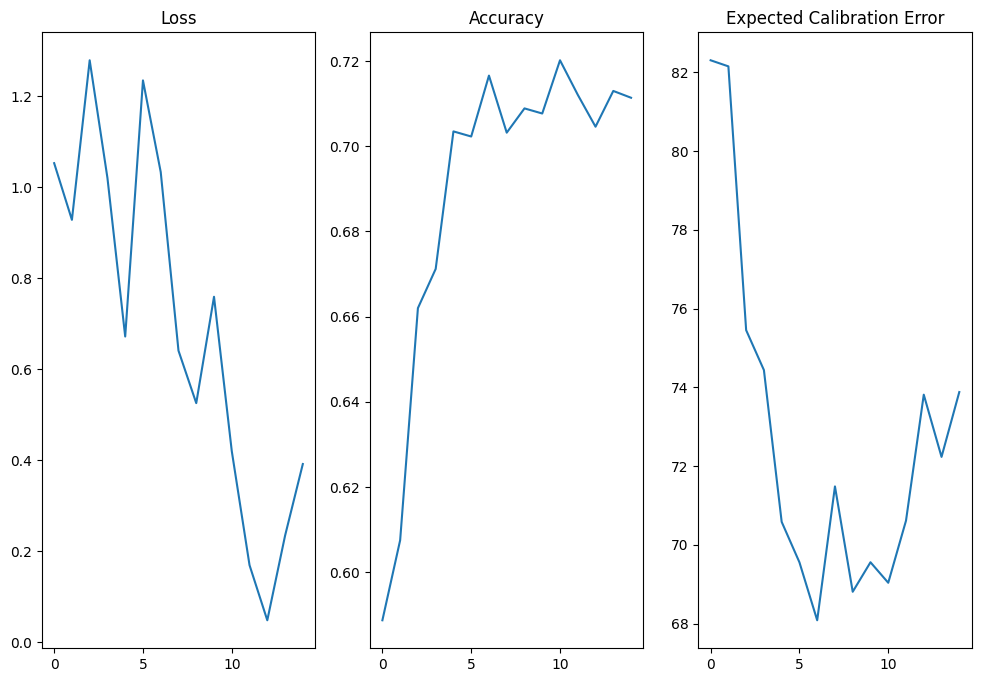

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].plot(loss_li)
ax[0].set_title('Loss')
ax[1].plot(acc_li)
ax[1].set_title('Accuracy')
ax[2].plot(epoch_error)
ax[2].set_title('Expected Calibration Error')
plt.show()

In [ ]:
import pandas as pd

metrics_df = pd.DataFrame({
    'Loss':loss_li,
    'Accuracy':acc_li,
    'ECE':epoch_error
}).reset_index(drop=False).rename(columns={'index':'Epoch'})
metrics_df

,Epoch,Loss,Accuracy,ECE
0,0,1.052846,0.5887,tensor(82.3054)
1,1,0.928234,0.6075,tensor(82.1508)
2,2,1.278962,0.6620,tensor(75.4527)
3,3,1.020375,0.6712,tensor(74.4391)
4,4,0.671806,0.7035,tensor(70.5851)
5,5,1.234732,0.7023,tensor(69.5582)
6,6,1.033292,0.7166,tensor(68.0861)
7,7,0.640724,0.7032,tensor(71.4848)
8,8,0.525403,0.7089,tensor(68.8100)
9,9,0.759186,0.7077,tensor(69.5594)


In [ ]:
save_path = '/content/drive/MyDrive/Projects/Temperature Scaling of NN/ResNetUnScaled.pth'

metrics_df.to_csv('/content/drive/MyDrive/Projects/Temperature Scaling of NN/ResNetUnScaledMetrics.csv',index=False)
checkpoint = {'model': ResNet18(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, save_path)

### Checking the optimal temperature for an unscaled model

In [ ]:
from tqdm import tqdm

def eval_step(temp_value:float):
    model.eval()
    epoch_calib_error = 0
    with torch.no_grad():
        for x, label in testset:
            x, label = x.to(device), label.to(device)
            logits = model(x)
            logits = logits/temp_value
            pred = logits.argmax(dim=1)
            batch_calib_error = error(logits.softmax(dim=1).detach().cpu(),label.cpu())
            epoch_calib_error = epoch_calib_error + batch_calib_error

    return epoch_calib_error

"""
    we try to scale the logits with random temperature
    values ranging from 0 to 1 with a step size of .10 as a grid
    search method to see if the values provided during training
    are the most optimal ones or not.
"""

response = []
temp_values = np.arange(1,2,0.1)

for temp in tqdm(temp_values,desc='Temp Values'):
    error_val = eval_step(temp)
    response.append({
        'Temp Value':temp,
        'ECE':error_val
    })
    # break

Temp Values: 100%|██████████| 10/10 [03:36<00:00, 21.66s/it]


In [ ]:
import pandas as pd
response = pd.DataFrame(response)
response

,Temp Value,ECE
0,1.0,tensor(74.7011)
1,1.1,tensor(72.5552)
2,1.2,tensor(70.9833)
3,1.3,tensor(70.6453)
4,1.4,tensor(70.1838)
5,1.5,tensor(68.3098)
6,1.6,tensor(68.4404)
7,1.7,tensor(67.9270)
8,1.8,tensor(68.3077)
9,1.9,tensor(68.2069)


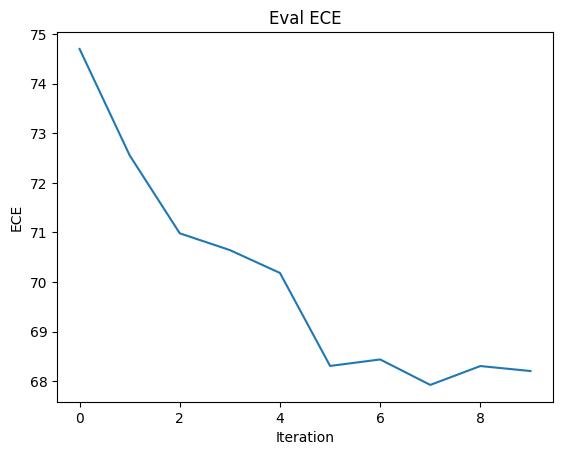

In [ ]:
import matplotlib.pyplot as plt

plt.plot(response['ECE'].tolist())
plt.xlabel('Iteration')
plt.ylabel('ECE')
plt.title('Eval ECE')
plt.show()